<a href="https://colab.research.google.com/github/Muhammadsulton1/ML/blob/main/cropping_detected_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies

Cloning into 'yolov5'...
remote: Enumerating objects: 15093, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 15093 (delta 0), reused 3 (delta 0), pack-reused 15088
Receiving objects: 100% (15093/15093), 13.68 MiB | 21.00 MiB/s, done.
Resolving deltas: 100% (10439/10439), done.
/content/yolov5
     |████████████████████████████████| 1.6 MB 4.3 MB/s 


In [2]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os
import torch

In [3]:
model = torch.hub.load('.', 'custom', path='/content/drive/MyDrive/best_200.pt', source='local') 

YOLOv5 🚀 v6.2-249-gff6e6e3 Python-3.7.15 torch-1.12.1+cu113 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


#предсказания координатов боундингбоксов

In [4]:
img = '/content/drive/MyDrive/crop_body_images/00121_t.jpg'
results = model(img)
print('\n', results.xyxy[0])



 tensor([[1.67759e+03, 1.13551e+02, 1.89297e+03, 3.78753e+02, 9.57266e-01, 0.00000e+00]])


In [5]:
image = cv2.imread('/content/drive/MyDrive/crop_body_images/00121_t.jpg')

In [6]:
image.shape

(1080, 1920, 3)

#координаты лицевой и задней части грузовика переводим в инты

In [7]:
def coor_to_int(results): #results.xyxy[0] уже так выглядит
  if len(results) == 0:
    coor_body_img = [0, 0, 0, 0]
    return coor_body_img
  else:
    coor_body_img = results[0][0:4].tolist()
    coor_body_img = list(map(int, coor_body_img))
  return coor_body_img

In [8]:
coor_body_img_yolo = coor_to_int(results.xyxy[0])

In [9]:
coor_body_img_yolo

[1677, 113, 1892, 378]

#читаем координаты из ткст файла

In [10]:
def read_file(file_path):
  with open(file_path) as f:
    lines = f.readlines()
  lines = lines[0].split()
  lines = lines[1:]
  lines = [float(x) for x in lines]
  return lines

In [11]:
cor_from_file = read_file('/content/drive/MyDrive/licplate_polygon/train/00121_t.txt')

In [12]:
cor_from_file

[1760.86, 343.32, 1812.59, 343.82, 1811.85, 355.7, 1760.12, 355.45]

#получаем координаты полигона

In [13]:
def get_polygon_coor(new_coor_licplate):
  new_coor_licplate = np.array(new_coor_licplate, dtype='int')
  new_coor_licplate = new_coor_licplate.reshape(-1,2)
  #new_coor_licplate = np.array(np.split(new_coor_licplate, 4))
  rect = cv2.minAreaRect(new_coor_licplate)
  box = cv2.boxPoints(rect)
  #box = np.int0(box)
  return box

In [14]:
coor_img_licplate = get_polygon_coor(cor_from_file)

#функция для ренормализации из формата йоло в xyxy

In [15]:
# def renorm_coor(x,h,w):
#   y = np.copy(x).astype(int)
#   y[0] = int(w * (x[0] - x[2] / 2))
#   y[1] = int(h * (x[1] - x[3] / 2))
#   y[2] = int(w * (x[0] + x[2] / 2))
#   y[3] = int(h * (x[1] + x[3] / 2))
#   return y

In [16]:
#coor_img_licplate = renorm_coor(cor, *image.shape[:2])

#вырезать изображения по предсказанным координатам йоло

In [17]:
def crop_body_on_img(img, coor_body_img_yolo):
  crop_top_left_x = coor_body_img_yolo[0]
  crop_top_left_y = coor_body_img_yolo[1]
  crop_bottom_right_x = coor_body_img_yolo[2]
  crop_bottom_right_y = coor_body_img_yolo[3]
  cropped_img = img[crop_top_left_y:crop_bottom_right_y, crop_top_left_x:crop_bottom_right_x]
  return cropped_img

In [18]:
croped_img = crop_body_on_img(image,coor_body_img_yolo).copy()

#функция для подсчета новых координат плашек по 4 координатам

In [19]:
# #функция для 4х координат кооректировка их
# def new_coor_licplate(coor_img_licplate, coor_body_img_yolo):
#   plate_t_left_x = coor_img_licplate[0]
#   plate_t_left_y = coor_img_licplate[1]
#   plate_b_right_x = coor_img_licplate[2]
#   plate_b_right_y = coor_img_licplate[3]
#   crop_top_left_x = coor_body_img_yolo[0]
#   crop_top_left_y = coor_body_img_yolo[1]
#   crop_bottom_right_x = coor_body_img_yolo[2]
#   crop_bottom_right_y = coor_body_img_yolo[3] 

#   new_p_t_l_x = plate_t_left_x - crop_top_left_x
#   new_p_t_l_y = plate_t_left_y - crop_top_left_y
#   new_p_b_r_x = plate_b_right_x - crop_top_left_x
#   new_p_b_r_y = plate_b_right_y - crop_top_left_y
#   new_coor_licplate = [new_p_t_l_x, new_p_t_l_y,new_p_b_r_x, new_p_b_r_y]
#   return new_coor_licplate

#функция для подсчета новых координат плашек по 8 координатам

In [20]:
def new_coor_licplate(coor_img_licplate, coor_body_img_yolo):
  plate_t_left_x, plate_t_left_y = coor_img_licplate[0]
  #print(plate_t_left_x)
  plate_t_right_x, plate_t_right_y  = coor_img_licplate[1]
  plate_b_right_x,plate_b_right_y = coor_img_licplate[2]
  plate_b_left_x, plate_b_left_y = coor_img_licplate[3]
  crop_top_left_x = coor_body_img_yolo[0]
  crop_top_left_y = coor_body_img_yolo[1]
  crop_bottom_right_x = coor_body_img_yolo[2]
  crop_bottom_right_y = coor_body_img_yolo[3]
  new_p_t_l_x = plate_t_left_x - crop_top_left_x
  new_p_t_l_y = plate_t_left_y - crop_top_left_y
  new_p_t_r_x = plate_t_right_x - crop_top_left_x
  new_p_t_r_y = plate_t_right_y - crop_top_left_y  
  new_p_b_r_x = plate_b_right_x - crop_top_left_x
  new_p_b_r_y = plate_b_right_y - crop_top_left_y
  #######################
  new_p_b_l_x = plate_b_left_x - crop_top_left_x
  new_p_b_l_y = plate_b_left_y - crop_top_left_y
  new_coor_licplate = [new_p_t_l_x, new_p_t_l_y, 
                       new_p_t_r_x, new_p_t_r_y, 
                       new_p_b_r_x, new_p_b_r_y, 
                       new_p_b_l_x, new_p_b_l_y]
                       
  return new_coor_licplate

In [21]:
new_coor = new_coor_licplate(coor_img_licplate, coor_body_img_yolo)

#переводим все в нужный формат для отрисовки контуров

In [22]:
new_coor = list(map(int, new_coor))
new_coor = np.array(new_coor)
new_coor = new_coor.reshape(-1,2)

In [23]:
new_coor

array([[ 83, 230],
       [135, 230],
       [135, 242],
       [ 83, 242]])

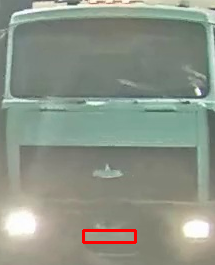

In [24]:
cv2_imshow(cv2.drawContours(croped_img.copy(), [new_coor] ,0,(0,0,255),2))

In [25]:
# def convertbox_to_yolo(new_coor, img):
#   x1 = new_coor[0]
#   y1 = new_coor[1]
#   x2 = new_coor[2]
#   y2 = new_coor[3]
#   image_h = image.shape[0]
#   image_w = image.shape[1]
#   return [round(((x2 + x1)/(2*image_w)),6), round(((y2 + y1)/(2*image_h)),6), round((x2 - x1)/image_w,6), round((y2 - y1)/image_h,6)]

In [26]:
os.mkdir('/content/anotations')
os.mkdir('/content/anotations/labels')
os.mkdir('/content/anotations/images')

#делаем пересечение поскольку на изображених были неотмеченны с наличием номерных плашек, а нам надо отобрать там где были номерные плашки

In [27]:
annotation_set = []
image_set = []
pictures = sorted(os.listdir('/content/drive/MyDrive/crop_body_images'))
annot = sorted(os.listdir('/content/drive/MyDrive/licplate_polygon/train'))
pictures = set([x.split('.')[0] for x in pictures])
annot = set([x.split('.')[0] for x in annot])
uniq_names = set.intersection(pictures, annot)

#эксперимент со многими картинками и аннотациями

In [31]:
for im in uniq_names:
  img = '/content/drive/MyDrive/crop_body_images/' + im + '.jpg'
  annot = '/content/drive/MyDrive/licplate_polygon/train/' + im + '.txt'
  results = model(img)
  img = cv2.imread(img)
  coor_body_img_yolo = coor_to_int(results.xyxy[0])
  cor_from_file = read_file(annot)
  coor_img_licplate = get_polygon_coor(cor_from_file)
  cropped_image = crop_body_on_img(img,coor_body_img_yolo)#.copy()
  #coor_img_licplate = renorm_coor(cor, *img.shape[:2]) #из формата йоло координат в нормальный формат
  new_coor = new_coor_licplate(coor_img_licplate, coor_body_img_yolo)
  new_coor = list(map(int, new_coor))
  new_coor = np.array(new_coor)
  box = new_coor.reshape(-1).tolist()
  #print(box)
  #box = get_polygon_coor(new_coor)
  cv2.imwrite('/content/anotations/images/'+ im +'.jpg',cropped_image)  
  with open(os.path.splitext('/content/anotations/labels/' + im)[0]+".txt" , "w+") as fp:
    fp.write("{} {} {} {} {} {} {} {} {}\n".format(0,box[0],box[1],box[2],box[3],box[4],box[5],box[6],box[7] ))

In [32]:
!zip -r /content/polygon_dataset.zip /content/anotations

  adding: content/anotations/ (stored 0%)
  adding: content/anotations/labels/ (stored 0%)
  adding: content/anotations/labels/0b027ed8ec7817b2e2d465de8f13d18222849685.txt (deflated 11%)
  adding: content/anotations/labels/0d605e3fa4b28ddd4b051b6367145774f4d2f52b.txt (deflated 21%)
  adding: content/anotations/labels/00388_t.txt (deflated 6%)
  adding: content/anotations/labels/00121_t.txt (deflated 31%)
  adding: content/anotations/labels/00202_t.txt (deflated 18%)
  adding: content/anotations/labels/87b89c8ea628f23490e3d339e1f476ca20b8820e.txt (deflated 3%)
  adding: content/anotations/labels/00218_t.txt (stored 0%)
  adding: content/anotations/labels/32530679f2bde1438fe3af14919ed9a5576d8c77.txt (deflated 12%)
  adding: content/anotations/labels/6a0c0c2b4109ca2a20184edc5a333e8118daeb37.txt (deflated 15%)
  adding: content/anotations/labels/f2757e82bef186240fb701a5acb7d7bdd42f810c.txt (stored 0%)
  adding: content/anotations/labels/b95938205afecf8eb1942a2df60adae13e7067cc.txt (deflate

In [33]:
from google.colab import files
files.download('/content/polygon_dataset.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>